In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
dataset_path = '/content/data'  # Replace with your dataset path
mask_path = os.path.join(dataset_path, 'with_mask')
no_mask_path = os.path.join(dataset_path, 'without_mask')

# Parameters
img_size = (128, 128)  # Size to which all images will be resized
num_classes = 2        # Number of classes (with_mask, without_mask)

In [5]:
# Function to load and preprocess images
def load_images_and_labels(mask_path, no_mask_path):
    images = []
    labels = []

    # Load images with mask
    for img_name in os.listdir(mask_path):
        img_path = os.path.join(mask_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
        labels.append(1)  # Label 1 for with_mask

    # Load images without mask
    for img_name in os.listdir(no_mask_path):
        img_path = os.path.join(no_mask_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
        labels.append(0)  # Label 0 for without_mask

    return np.array(images), np.array(labels)

In [6]:
images, labels = load_images_and_labels(mask_path, no_mask_path)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [7]:
# Data Augmentation (optional)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
train_datagen.fit(X_train)

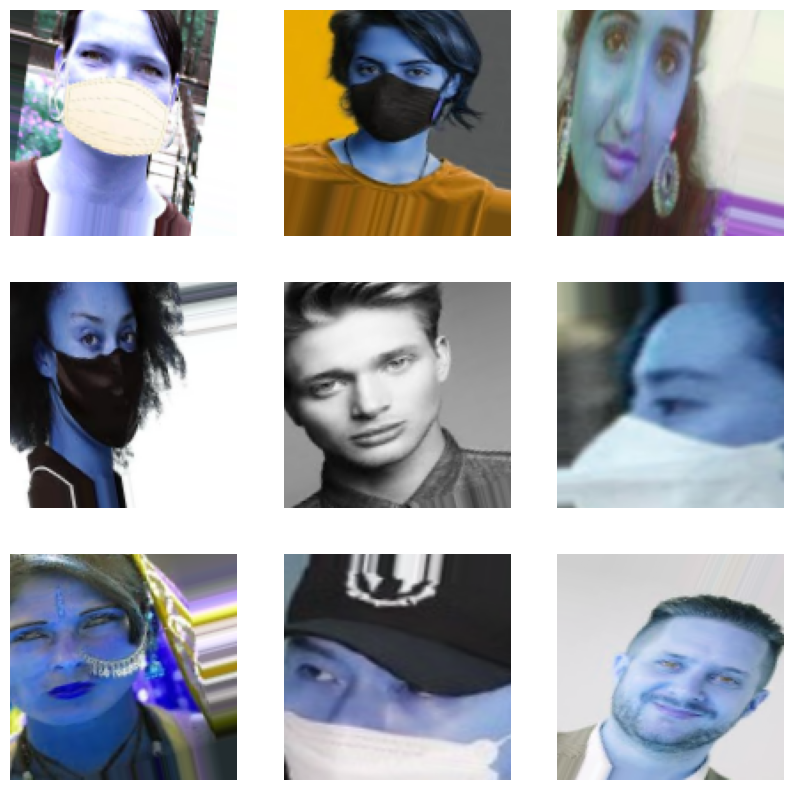

In [8]:
# Visualize some of the augmented images
augmented_images = train_datagen.flow(X_train, y_train, batch_size=1)

# Plot some augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    img, label = next(augmented_images)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])
    plt.axis('off')
plt.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after first pool
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after second pool
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout after third pool
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),   # Dropout before output layer
    Dense(1, activation='sigmoid')  # Using sigmoid for binary classification
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.6520 - loss: 0.6206 - val_accuracy: 0.8683 - val_loss: 0.3548
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.8242 - loss: 0.4019 - val_accuracy: 0.8941 - val_loss: 0.2868
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.8468 - loss: 0.3711 - val_accuracy: 0.8795 - val_loss: 0.2792
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.8569 - loss: 0.3433 - val_accuracy: 0.9146 - val_loss: 0.2122
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - accuracy: 0.8748 - loss: 0.3040 - val_accuracy: 0.9226 - val_loss: 0.2040
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.8791 - loss: 0.2917 - val_accuracy: 0.9292 - val_loss: 0.1876
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.8929 - loss: 0.2757 - val_accuracy: 0.9418 - val_loss: 0.1747
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - accuracy: 0.8991 - loss: 0.2710 - val

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

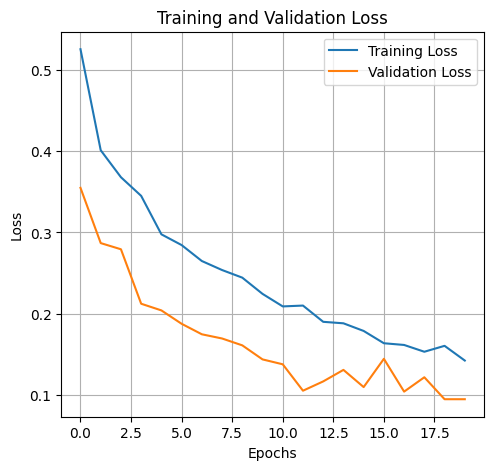

In [13]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

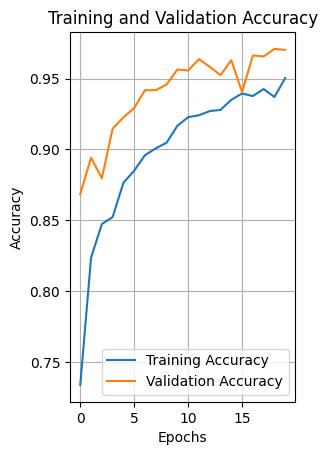

In [14]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: With Mask


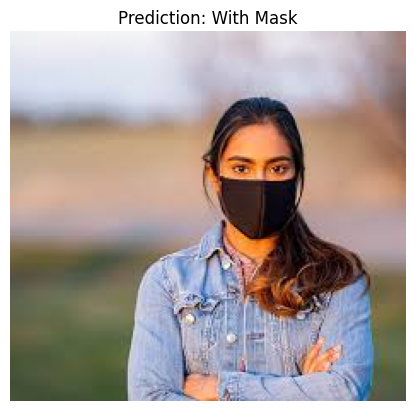

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # Load image from file
    img = image.load_img(img_path, target_size=target_size)

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Normalize the image (pixel values between 0 and 1)
    img_array /= 255.0

    # Reshape to match the input shape of the model (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Path to your image (replace with the path of your uploaded image)
image_path = "/content/masked.jpeg"

# Load and preprocess the image
test_image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(test_image)

# Get the class label (0 for "without_mask", 1 for "with_mask")
predicted_class = (prediction > 0.5).astype("int32")[0][0]

# Map class labels to actual labels
labels = {0: "Without Mask", 1: "With Mask"}

# Display the result
print(f"Predicted Class: {labels[predicted_class]}")

# Optionally, display the image with the prediction
plt.imshow(image.load_img(image_path))
plt.title(f"Prediction: {labels[predicted_class]}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: Without Mask


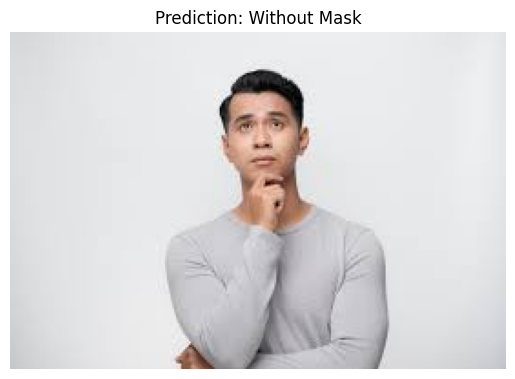

In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    # Load image from file
    img = image.load_img(img_path, target_size=target_size)

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Normalize the image (pixel values between 0 and 1)
    img_array /= 255.0

    # Reshape to match the input shape of the model (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Path to your image (replace with the path of your uploaded image)
image_path = "/content/unmasked.jpeg"

# Load and preprocess the image
test_image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(test_image)

# Get the class label (0 for "without_mask", 1 for "with_mask")
predicted_class = (prediction > 0.5).astype("int32")[0][0]

# Map class labels to actual labels
labels = {0: "Without Mask", 1: "With Mask"}

# Display the result
print(f"Predicted Class: {labels[predicted_class]}")

# Optionally, display the image with the prediction
plt.imshow(image.load_img(image_path))
plt.title(f"Prediction: {labels[predicted_class]}")
plt.axis('off')
plt.show()

In [17]:
import pickle

# Save the trained model to a .pkl file
with open('mask_detector_model.pkl', 'wb') as f:
    pickle.dump(model, f)